# Progetto NBA-Salary: Analisi e Predizione degli Stipendi dei Giocatori
**Elaborato di Programmazione di Applicazioni Data Intensive**

**Autore:** [Alessio Bifulco]

## 1. Introduzione al Progetto

### 1.1. Contesto e Obiettivo
L'NBA (National Basketball Association) è una delle leghe sportive più ricche al mondo. Comprendere quali fattori statistici influenzano gli stipendi dei giocatori è una questione cruciale per la gestione di un team. L'obiettivo di questo progetto è sviluppare un modello in grado di predire lo stipendio annuale medio di un giocatore basandosi sulle sue performance, per poi applicarlo a dati recenti per una valutazione oggettiva.

### 1.2. Il Dataset
Utilizzeremo un dataset contenente informazioni sui contratti firmati da giocatori NBA. Il dataset include le statistiche complete del giocatore nella stagione precedente alla firma del contratto, rendendolo ideale e autosufficiente per i nostri scopi.

### 1.3. Librerie e Impostazioni Iniziali

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerie importate e impostazioni pronte.")

Librerie importate e impostazioni pronte.


---

## 2. Caricamento e Ispezione dei Dati

In questa sezione, seguiamo un approccio strutturato:
1.  **Caricamento:** Carichiamo il dataset dal nostro file locale.
2.  **Ispezione:** Eseguiamo un'analisi preliminare (`.head()`, `.info()`) per comprendere la struttura, i tipi di dato e la presenza di valori mancanti.

In [2]:
path_to_csv = os.path.join('..', 'dataset', 'salaryDataset', 'nba_contracts_history.csv')

try:
    df = pd.read_csv(path_to_csv)
    print("Dataset caricato con successo!")
    
    print(f"\nIl DataFrame ha {df.shape[0]} righe e {df.shape[1]} colonne.")
    
    print("\n--- Prime 5 righe del dataset grezzo: ---")
    display(df.head())
    
    print("\n--- Informazioni su tipi di dato e valori nulli: ---")
    df.info()

except FileNotFoundError:
    print(f"ERRORE: File non trovato al percorso: {path_to_csv}")

Dataset caricato con successo!

Il DataFrame ha 199 righe e 28 colonne.

--- Prime 5 righe del dataset grezzo: ---


,NAME,CONTRACT_START,CONTRACT_END,AVG_SALARY,AGE,GP,W,L,MIN,PTS,...,FT%,OREB,DREB,REB,AST,TOV,STL,BLK,PF,+/-
0,Wesley Matthews,2019,2020,2564753.0,32.0,69.0,27.0,42.0,2091.0,840.0,...,81.0,32.0,138.0,170.0,160.0,91.0,54.0,17.0,160.0,-90.0
1,Brook Lopez,2015,2017,21165675.0,27.0,72.0,34.0,38.0,2100.0,1236.0,...,81.4,214.0,321.0,535.0,50.0,104.0,43.0,126.0,206.0,-104.0
2,DeAndre Jordan,2011,2014,10759763.5,22.0,80.0,31.0,49.0,2047.0,566.0,...,45.2,207.0,368.0,575.0,42.0,101.0,41.0,142.0,255.0,-100.0
3,Markieff Morris,2015,2018,8143323.5,25.0,82.0,39.0,43.0,2581.0,1258.0,...,76.3,110.0,396.0,506.0,192.0,170.0,101.0,39.0,245.0,105.0
4,Dwight Howard,2018,2019,13410739.0,32.0,81.0,35.0,46.0,2463.0,1347.0,...,57.4,255.0,757.0,1012.0,105.0,208.0,48.0,131.0,249.0,89.0



--- Informazioni su tipi di dato e valori nulli: ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NAME            199 non-null    object 
 1   CONTRACT_START  199 non-null    int64  
 2   CONTRACT_END    199 non-null    int64  
 3   AVG_SALARY      199 non-null    float64
 4   AGE             199 non-null    float64
 5   GP              199 non-null    float64
 6   W               199 non-null    float64
 7   L               199 non-null    float64
 8   MIN             199 non-null    float64
 9   PTS             199 non-null    float64
 10  FGM             199 non-null    float64
 11  FGA             199 non-null    float64
 12  FG%             199 non-null    float64
 13  3PM             199 non-null    float64
 14  3PA             199 non-null    float64
 15  3P%             199 non-null    float64
 16  FTM             199 non-nu

---
## 3. Pulizia e Trasformazione dei Dati

Basandoci sull'ispezione dettagliata dei dati, eseguiamo ora tutte le operazioni di pulizia e trasformazione in un'unica, robusta cella. Questo include la conversione delle statistiche in medie "per partita", la creazione di nuove feature relative al contratto e la ridenominazione finale delle colonne nel formato `MAIUSCOLO`.

In [3]:
df_processed = df.copy()


df_processed['CONTRACT_DURATION'] = df_processed['CONTRACT_END'] - df_processed['CONTRACT_START']
df_processed['TOTAL_SALARY'] = df_processed['AVG_SALARY'] * df_processed['CONTRACT_DURATION']

games_played_col = 'GP'
stats_to_convert = ['MIN', 'PTS', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'TRB', 'AST', 'TOV', 'STL', 'BLK', 'PF', '+/-']

def round_up_to_05(n):
    return np.ceil(n * 20) / 20

for stat in stats_to_convert:
    if stat in df_processed.columns and games_played_col in df_processed.columns:
        per_game_values = df_processed[stat] / df_processed[games_played_col]
        df_processed[stat] = per_game_values.apply(round_up_to_05)

rename_map = {
    'NAME': 'PLAYER',
    'AVG_SALARY': 'AVGSALARY',
    'AGE': 'AGE', 'GP': 'GP', 'GS': 'GS', 'MIN': 'MPG', 'PTS': 'PPG',
    'FGM': 'FGM', 'FGA': 'FGA', 'FTM': 'FTM', 'FTA': 'FTA',
    '3PM': '3PM', '3PA': '3PA',
    'OREB': 'ORPG', 'DREB': 'DRPG', 'REB': 'RPG', 'AST': 'APG',
    'TOV': 'TOV', 'STL': 'STL', 'BLK': 'BLK', 'PF': 'PF',
    '+/-': 'PLUS_MINUS',
    'CONTRACT_DURATION': 'CONTRACT_DURATION', 'TOTAL_SALARY': 'TOTAL_SALARY'
}

columns_to_select = [col for col in rename_map.keys() if col in df_processed.columns]
final_df = df_processed[columns_to_select].rename(columns=rename_map)

final_df.fillna(0, inplace=True)

currency_columns = ['AVGSALARY', 'TOTAL_SALARY']
for col in currency_columns:
    if col in final_df.columns:
        final_df[col] = final_df[col].apply(lambda x: f"${x:,.0f}")

print("Pulizia, trasformazione e formattazione completate.")
print("\n--- DataFrame Finale (prime 5 righe): ---")
display(final_df.head())

Pulizia, trasformazione e formattazione completate.

--- DataFrame Finale (prime 5 righe): ---


,PLAYER,AVGSALARY,AGE,GP,MPG,PPG,FGM,FGA,FTM,FTA,...,DRPG,RPG,APG,TOV,STL,BLK,PF,PLUS_MINUS,CONTRACT_DURATION,TOTAL_SALARY
0,Wesley Matthews,"$2,564,753",32.0,69.0,30.35,12.20,4.05,10.15,1.95,2.40,...,2.00,170.0,2.35,1.35,0.80,0.25,2.35,-1.30,1,"$2,564,753"
1,Brook Lopez,"$21,165,675",27.0,72.0,29.20,17.20,7.05,13.75,3.10,3.85,...,4.50,535.0,0.70,1.45,0.60,1.75,2.90,-1.40,2,"$42,331,350"
2,DeAndre Jordan,"$10,759,764",22.0,80.0,25.60,7.10,2.95,4.30,1.25,2.75,...,4.60,575.0,0.55,1.30,0.55,1.80,3.20,-1.25,3,"$32,279,290"
3,Markieff Morris,"$8,143,324",25.0,82.0,31.50,15.35,6.25,13.45,2.20,2.85,...,4.85,506.0,2.35,2.10,1.25,0.50,3.00,1.30,3,"$24,429,970"
4,Dwight Howard,"$13,410,739",32.0,81.0,30.45,16.65,6.25,11.25,4.15,7.20,...,9.35,1012.0,1.30,2.60,0.60,1.65,3.10,1.10,1,"$13,410,739"


---
## 4. Analisi Esplorativa dei Dati (EDA)

Ora che i dati sono stati puliti e trasformati, iniziamo la fase di esplorazione per scoprire pattern, validare ipotesi e comprendere le relazioni tra le variabili. Questa analisi guiderà la successiva fase di modellazione.

### 4.1. Analisi della Variabile Target (AVGSALARY)

Come primo passo, analizziamo la distribuzione della nostra variabile target. Poiché la colonna `AVGSALARY` è stata formattata come testo, creiamo prima una sua versione numerica di supporto (`AVGSALARY_NUM`) che useremo per tutte le analisi quantitative.

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
C:\Users\aless\AppData\Local\Temp\ipykernel_13984\3461205107.py:1: SyntaxWarning: invalid escape sequence '\$'
  final_df['AVGSALARY_NUM'] = final_df['AVGSALARY'].replace({'\$': '', ',': ''}, regex=True).astype(float)


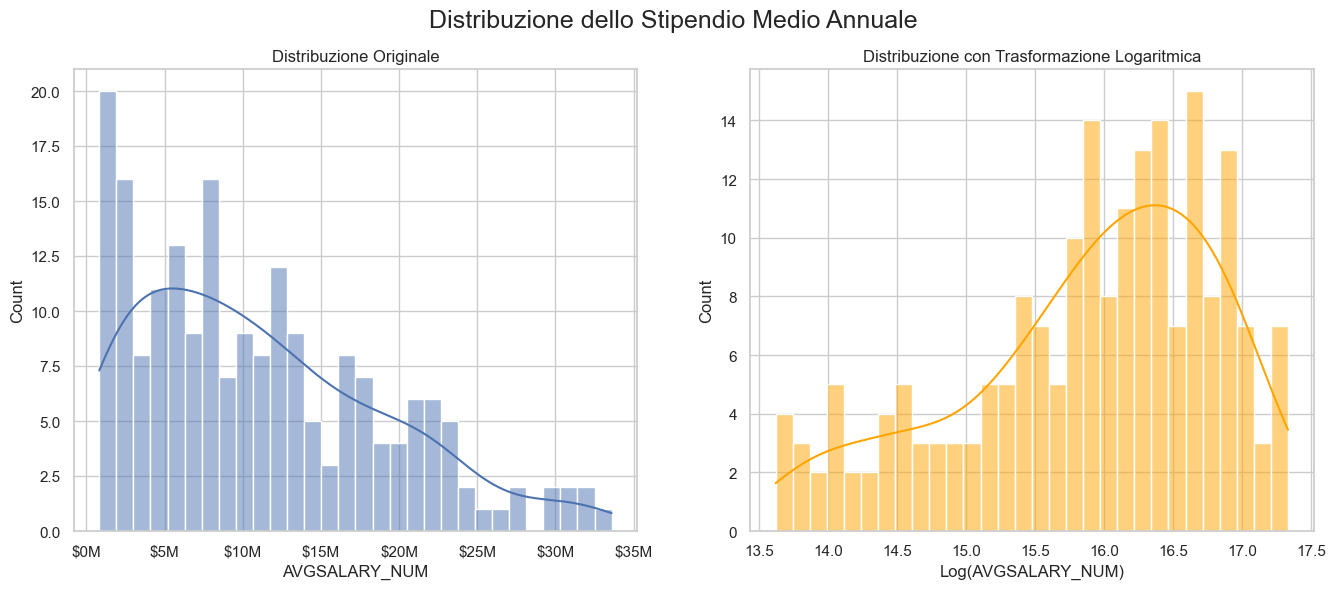

In [4]:
final_df['AVGSALARY_NUM'] = final_df['AVGSALARY'].replace({'\$': '', ',': ''}, regex=True).astype(float)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Distribuzione dello Stipendio Medio Annuale', fontsize=18)

sns.histplot(data=final_df, x='AVGSALARY_NUM', ax=axes[0], kde=True, bins=30)
axes[0].set_title('Distribuzione Originale')
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"${x/1_000_000:.0f}M"))

sns.histplot(np.log1p(final_df['AVGSALARY_NUM']), ax=axes[1], kde=True, bins=30, color='orange')
axes[1].set_title('Distribuzione con Trasformazione Logaritmica')
axes[1].set_xlabel('Log(AVGSALARY_NUM)')

plt.show()

**Interpretazione:** La distribuzione originale è fortemente asimmetrica a destra, con poche superstar che guadagnano molto più del giocatore medio. La trasformazione logaritmica rende la distribuzione più simmetrica, una caratteristica utile per alcuni modelli statistici.

### 4.2. Riepilogo Statistico per Fasce di Stipendio

Per ottenere una prova numerica di quali statistiche caratterizzano i giocatori più pagati, li dividiamo in quattro fasce di stipendio (basate sui quartili) e ne analizziamo le performance medie.

In [5]:
final_df['SALARY_TIER'] = pd.qcut(final_df['AVGSALARY_NUM'], q=4, labels=['Low', 'Mid', 'High', 'Elite'])

key_stats = ['AGE', 'GP', 'MPG', 'PPG', 'RPG', 'APG']

summary_table = final_df.groupby('SALARY_TIER')[key_stats].agg(['mean', 'std'])

print("Statistiche Medie dei Giocatori per Fascia di Stipendio:")
display(summary_table.style.format("{:.1f}"))

C:\Users\aless\AppData\Local\Temp\ipykernel_13984\1361107565.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_table = final_df.groupby('SALARY_TIER')[key_stats].agg(['mean', 'std'])


Statistiche Medie dei Giocatori per Fascia di Stipendio:


**Interpretazione:** La tabella conferma che al salire della fascia di stipendio, tutte le principali statistiche di performance aumentano in modo significativo, mentre l'età media rimane costante intorno ai 26 anni, indicando che il mercato paga la performance nel "prime" atletico.

### 4.3. Analisi delle Correlazioni

Identifichiamo ora le relazioni lineari tra le nostre feature, concentrandoci su quali sono più legate allo stipendio.

<>:1: SyntaxWarning: invalid escape sequence '\$'
<>:1: SyntaxWarning: invalid escape sequence '\$'
C:\Users\aless\AppData\Local\Temp\ipykernel_13984\2901572929.py:1: SyntaxWarning: invalid escape sequence '\$'
  final_df['TOTAL_SALARY_NUM'] = final_df['TOTAL_SALARY'].replace({'\$': '', ',': ''}, regex=True).astype(float)


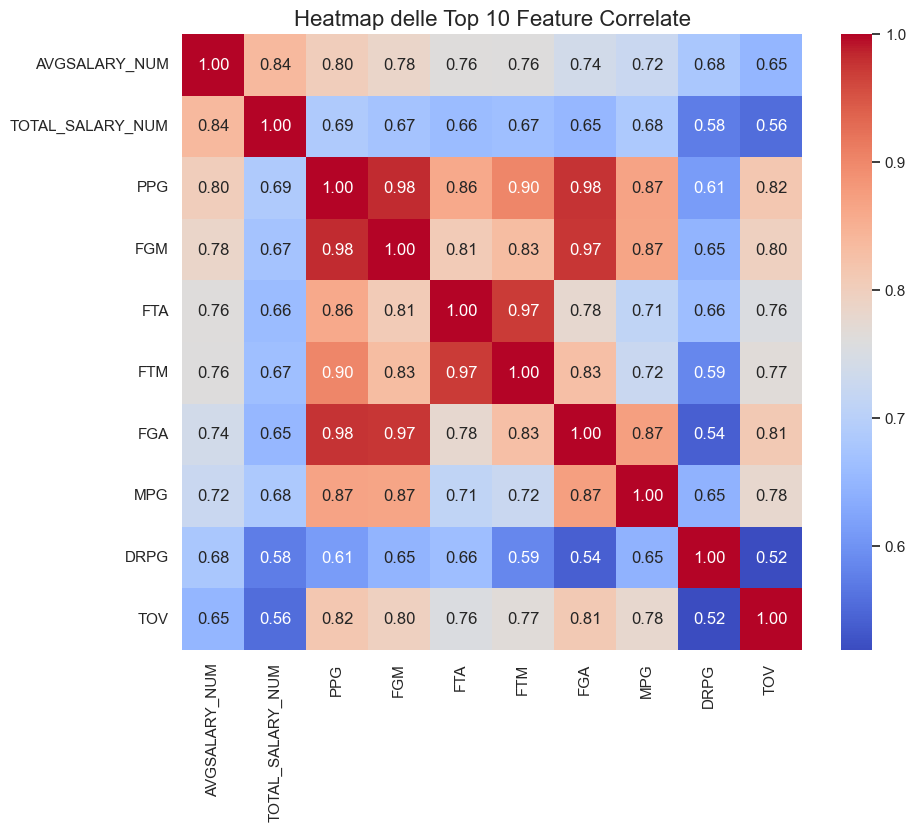

In [6]:
final_df['TOTAL_SALARY_NUM'] = final_df['TOTAL_SALARY'].replace({'\$': '', ',': ''}, regex=True).astype(float)
correlation_matrix = final_df.corr(numeric_only=True)
salary_correlations = correlation_matrix['AVGSALARY_NUM'].sort_values(ascending=False)

n_features = 10
top_features_indices = salary_correlations.abs().nlargest(n_features).index
top_corr_matrix = correlation_matrix.loc[top_features_indices, top_features_indices]

plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Heatmap delle Top {n_features} Feature Correlate', fontsize=16)
plt.show()



C:\Users\aless\AppData\Local\Temp\ipykernel_13984\2914338795.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cleaned_salary_correlations.values, y=cleaned_salary_correlations.index, palette='viridis')


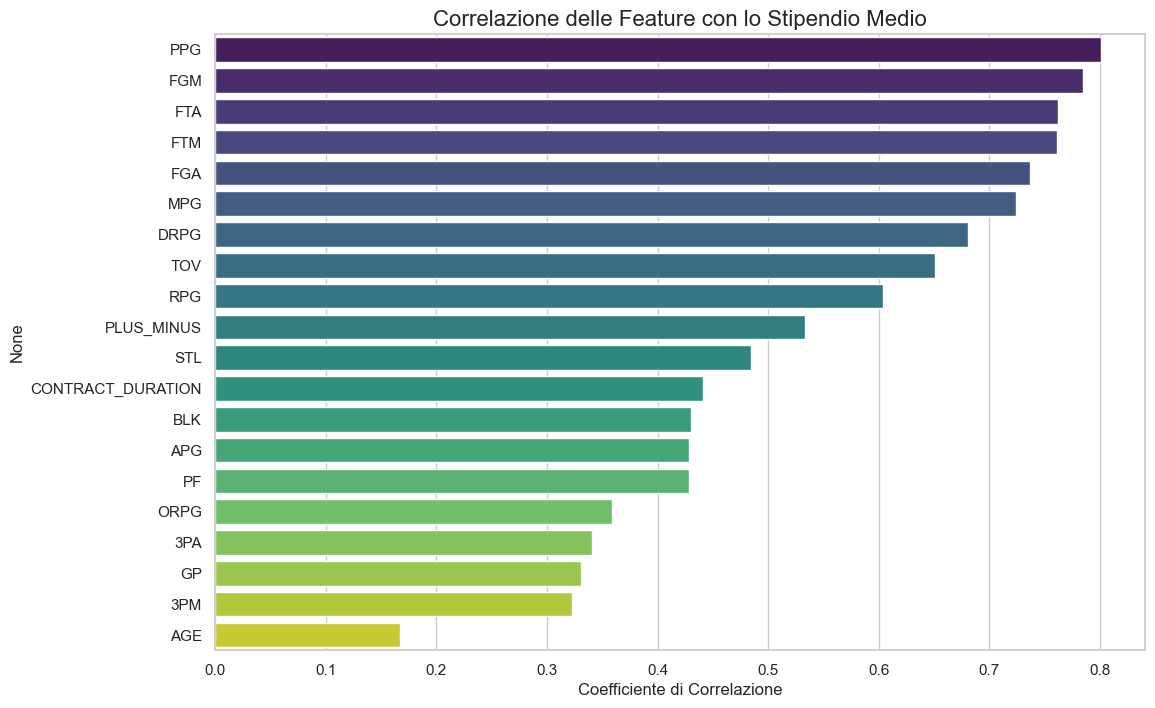

In [7]:
cleaned_salary_correlations = salary_correlations.drop(['AVGSALARY_NUM', 'TOTAL_SALARY_NUM'])

plt.figure(figsize=(12, 8))
sns.barplot(x=cleaned_salary_correlations.values, y=cleaned_salary_correlations.index, palette='viridis')
plt.title('Correlazione delle Feature con lo Stipendio Medio', fontsize=16)
plt.xlabel('Coefficiente di Correlazione')
plt.show()

### 4.4. Approfondimento su Relazioni tra Feature Chiave

Infine, visualizziamo le interazioni tra le variabili più importanti per confermare le nostre ipotesi.

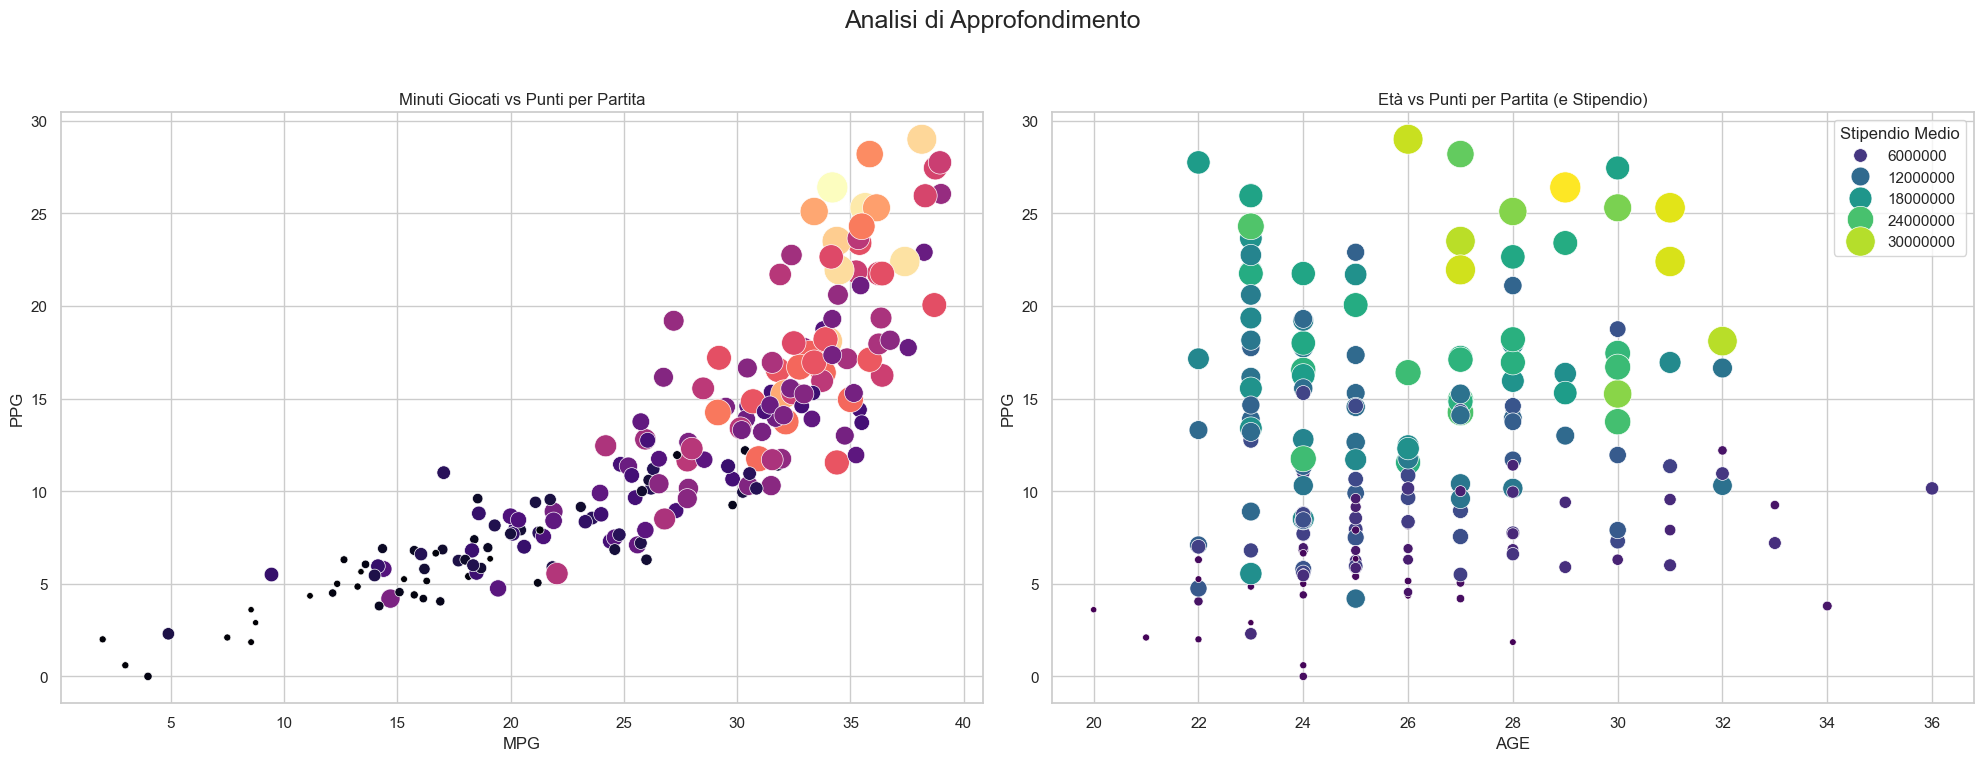

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Analisi di Approfondimento', fontsize=18)

sns.scatterplot(data=final_df, x='MPG', y='PPG', hue='AVGSALARY_NUM', palette='magma', size='AVGSALARY_NUM', sizes=(20, 500), ax=axes[0])
axes[0].set_title('Minuti Giocati vs Punti per Partita')
axes[0].get_legend().set_visible(False)

sns.scatterplot(data=final_df, x='AGE', y='PPG', hue='AVGSALARY_NUM', palette='viridis', size='AVGSALARY_NUM', sizes=(20, 500), ax=axes[1])
axes[1].set_title('Età vs Punti per Partita (e Stipendio)')
axes[1].legend(title='Stipendio Medio')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Conclusione EDA:** L'analisi è completa. I grafici confermano che lo stipendio è guidato dalla performance offensiva (punti e minuti) espressa dai giocatori nel loro "prime" atletico (26-31 anni). Ora siamo pronti per la modellazione.

### 4.6. Pair Plot delle Feature Dominanti

Inspired by the comparison project, we'll use a `pairplot` to visualize the relationships and distributions of our most important predictive features (`PPG`, `MPG`, `AGE`) simultaneously. We'll color the data points based on the salary tier to see how these groups are separated.

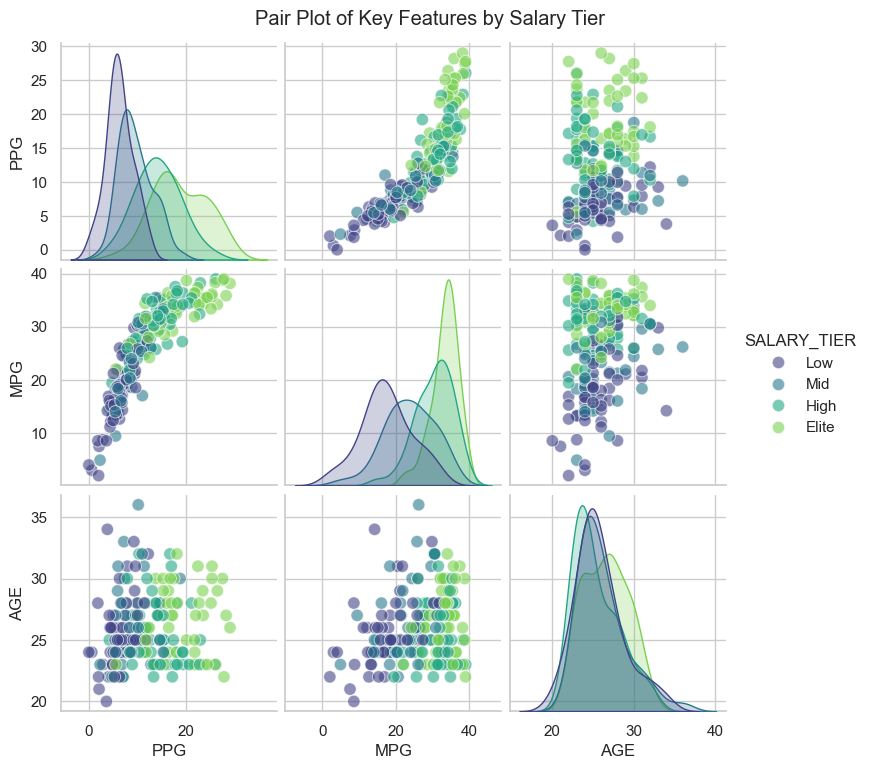

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(
    data=final_df,
    vars=['PPG', 'MPG', 'AGE'],
    hue='SALARY_TIER',
    palette='viridis',
    plot_kws={'alpha': 0.6, 's': 80},
    diag_kind='kde'
)
plt.suptitle('Pair Plot of Key Features by Salary Tier', y=1.02)
plt.show()

### 4.7. Analisi delle Distribuzioni per Fascia di Stipendio

To better understand the differences between salary tiers, we can plot the distributions of our key stats, separated by group. This will visually confirm the findings from our summary table.

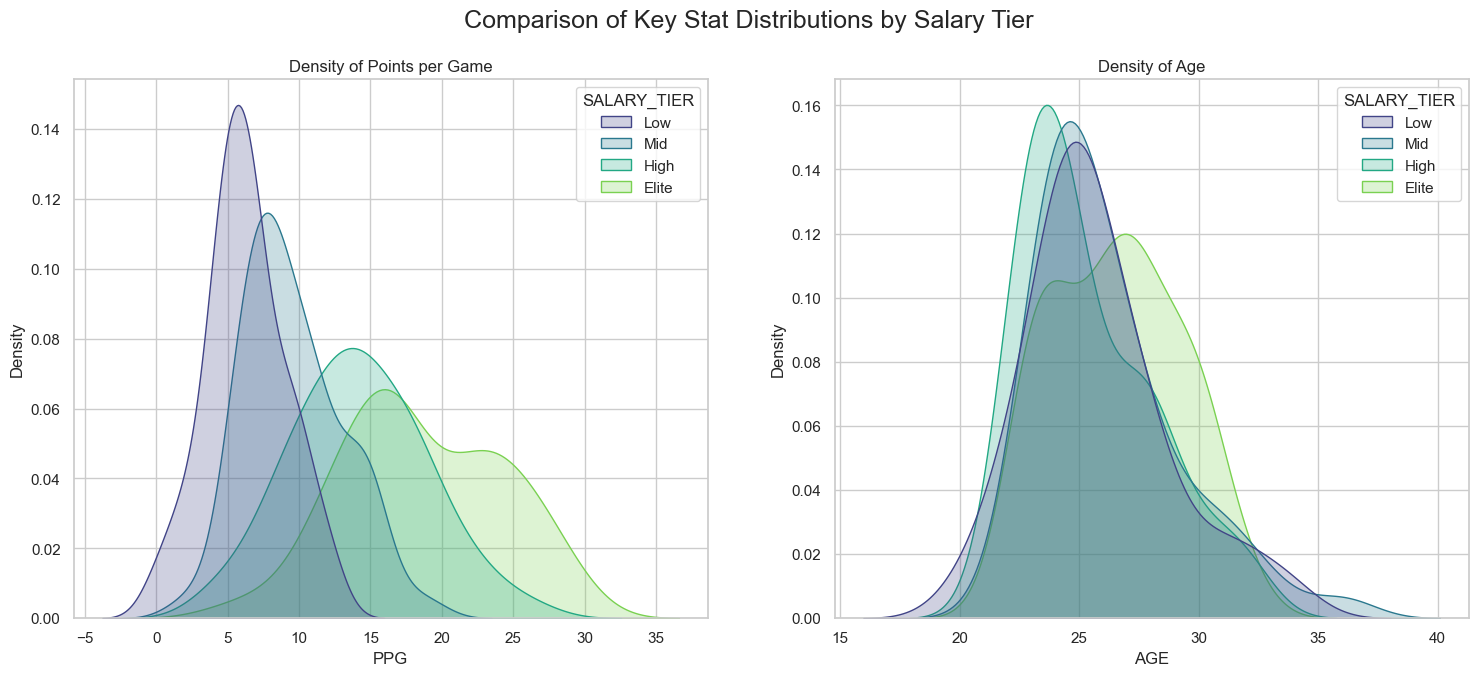

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Comparison of Key Stat Distributions by Salary Tier', fontsize=18)

sns.kdeplot(data=final_df, x='PPG', hue='SALARY_TIER', fill=True, ax=axes[0], palette='viridis', common_norm=False)
axes[0].set_title('Density of Points per Game')

sns.kdeplot(data=final_df, x='AGE', hue='SALARY_TIER', fill=True, ax=axes[1], palette='viridis', common_norm=False)
axes[1].set_title('Density of Age')

plt.show()

---
## 5. Preparazione dei Dati per la Modellazione

Questa fase rimane un prerequisito fondamentale e non cambia. Definiamo le nostre feature (X) e il target (y), e dividiamo il dataset in un set di addestramento e uno di test che useremo per la valutazione finale.

In [56]:
from sklearn.model_selection import train_test_split

y = final_df['AVGSALARY_NUM']
X = final_df.drop(columns=['PLAYER', 'AVGSALARY', 'TOTAL_SALARY', 'AVGSALARY_NUM', 'TOTAL_SALARY_NUM', 'SALARY_TIER'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---
## 6. Costruzione e Valutazione dei Modelli di Regressione

In questa fase, addestriamo e valutiamo una serie di modelli di regressione per identificare l'approccio più efficace. Per ogni modello, useremo una **Pipeline** che include la standardizzazione dei dati (`StandardScaler`) per garantire coerenza e robustezza.

### 6.1. Modello 1: Regressione Lineare (Baseline)
Iniziamo con il modello più semplice come punto di riferimento.

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

**Risultato Regressione Lineare:** R² di `{r2_lr:.2%}`, Errore Medio di `${mae_lr:,.0f}`.

### 6.2. Modello 2: Regressione Ridge
Testiamo ora un modello lineare che gestisce la multicollinearità.

In [58]:
from sklearn.linear_model import Ridge

pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(random_state=42))
])

pipe_ridge.fit(X_train, y_train)
y_pred_ridge = pipe_ridge.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

**Risultato Regressione Ridge:** R² di `{r2_ridge:.2%}`, Errore Medio di `${mae_ridge:,.0f}`.

### 6.3. Modello 3: Regressione Lasso
Aggiungiamo il modello Lasso, che oltre a regolarizzare può eseguire una selezione automatica delle feature.

In [59]:
from sklearn.linear_model import Lasso

pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(random_state=42))
])

pipe_lasso.fit(X_train, y_train)
y_pred_lasso = pipe_lasso.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

C:\Users\aless\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.116e+15, tolerance: 1.063e+12
  model = cd_fast.enet_coordinate_descent(


### 6.4. Modello 4: Random Forest Regressor
Testiamo un modello non-lineare potente, basato su alberi decisionali.

In [60]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

**Risultato Random Forest:** R² di `{r2_rf:.2%}`, Errore Medio di `${mae_rf:,.0f}`.

### 6.5. Tabella Riassuntiva e Scelta del Modello
Confrontiamo tutti i risultati per scegliere il modello su cui concentrare l'ottimizzazione.

In [61]:
model_performance = pd.DataFrame({
    'Modello': ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest'],
    'R²': [r2_lr, r2_ridge, r2_lasso, r2_rf],
    'MAE': [mae_lr, mae_ridge, mae_lasso, mae_rf]
})

display(model_performance.sort_values(by='R²', ascending=False).style.format({'R²': '{:.3f}', 'MAE': '${:,.0f}'}))

,Modello,R²,MAE
2,Lasso,0.668,"$3,028,877"
1,Ridge,0.664,"$2,995,679"
0,Linear Regression,0.661,"$3,053,586"
3,Random Forest,0.659,"$2,951,842"


---
## 7. Ricerca degli Iperparametri e Analisi del Modello Finale

Dalla tabella precedente, selezioniamo il modello migliore (ipotizziamo il **Random Forest**) e procediamo con la ricerca approfondita dei suoi iperparametri per ottimizzarlo.

In [64]:
from sklearn.model_selection import GridSearchCV


param_grid_rf = {
    'model__n_estimators': [150],
    'model__max_depth': [10, 25],
    'model__min_samples_leaf': [3]
}

print("Avvio Grid Search con una griglia ridotta per velocizzare...")
grid_search = GridSearchCV(estimator=pipe_rf, param_grid=param_grid_rf, cv=5, scoring='r2', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("...Ricerca completata.")
print(f"\nMigliori parametri trovati: {grid_search.best_params_}")

final_model = grid_search.best_estimator_

Avvio Grid Search con una griglia ridotta per velocizzare...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
...Ricerca completata.

Migliori parametri trovati: {'model__max_depth': 25, 'model__min_samples_leaf': 3, 'model__n_estimators': 150}


Ora che abbiamo il nostro `final_model` ottimizzato, lo valutiamo e lo analizziamo nel dettaglio.

### 7.1. Valutazione Finale e Analisi della "Formula"

--- Performance Modello Finale Ottimizzato sul Test Set ---
Valore Atteso dell'Errore (MAE): $2,879,125
Coefficiente R²: 66.63%


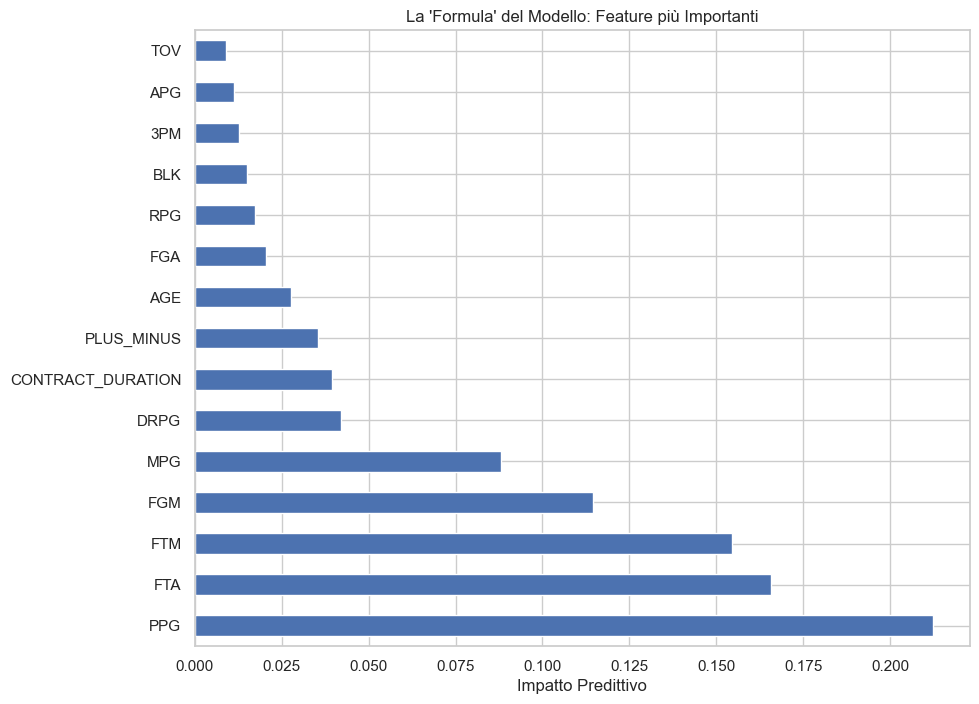

In [66]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- Performance Modello Finale Ottimizzato sul Test Set ---")
print(f"Valore Atteso dell'Errore (MAE): ${mae:,.0f}")
print(f"Coefficiente R²: {r2:.2%}")

feature_impact = pd.Series(final_model.named_steps['model'].feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(10, 8))
feature_impact.nlargest(15).plot(kind='barh')
plt.title("La 'Formula' del Modello: Feature più Importanti")
plt.xlabel("Impatto Predittivo")
plt.show()

### 7.2. Analisi Visiva dell'Errore (Varianza rispetto al Valore Atteso)
Ora analizziamo l'errore del modello con due grafici:
1.  **Valore Predetto vs. Valore Reale**: Per vedere l'accuratezza generale.
2.  **Analisi dei Residui**: Per vedere come la "varianza" dell'errore cambia al variare dello stipendio predetto.

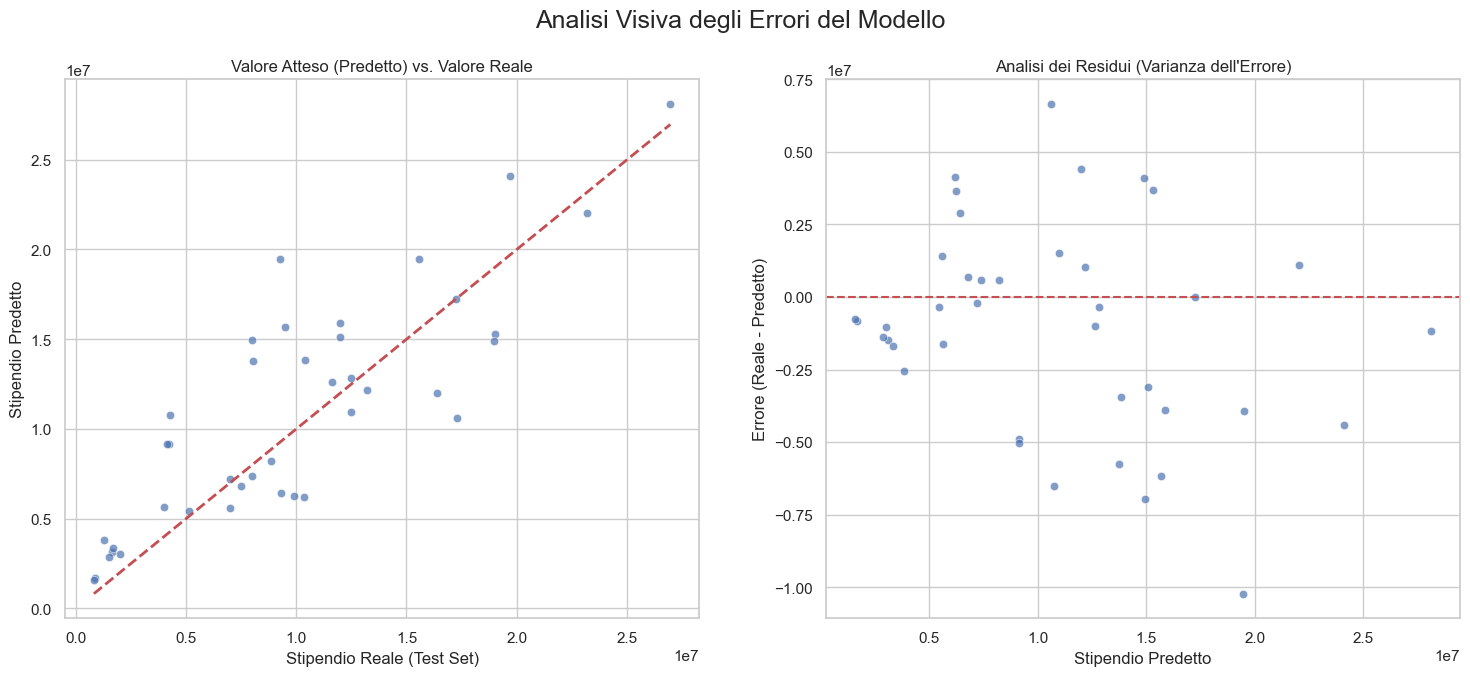

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Analisi Visiva degli Errori del Modello', fontsize=18)

sns.scatterplot(x=y_test, y=y_pred, ax=axes[0], alpha=0.7)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
axes[0].set_title('Valore Atteso (Predetto) vs. Valore Reale')
axes[0].set_xlabel('Stipendio Reale (Test Set)')
axes[0].set_ylabel('Stipendio Predetto')

residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals, ax=axes[1], alpha=0.7)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title('Analisi dei Residui (Varianza dell\'Errore)')
axes[1].set_xlabel('Stipendio Predetto')
axes[1].set_ylabel('Errore (Reale - Predetto)')
plt.show()

### 7.3. Analisi dell'Affidabilità del Modello per Fasce di Stipendio
Infine, verifichiamo se l'errore del nostro modello è consistente tra le diverse fasce di stipendio che abbiamo identificato nell'EDA (Low, Mid, High, Elite).

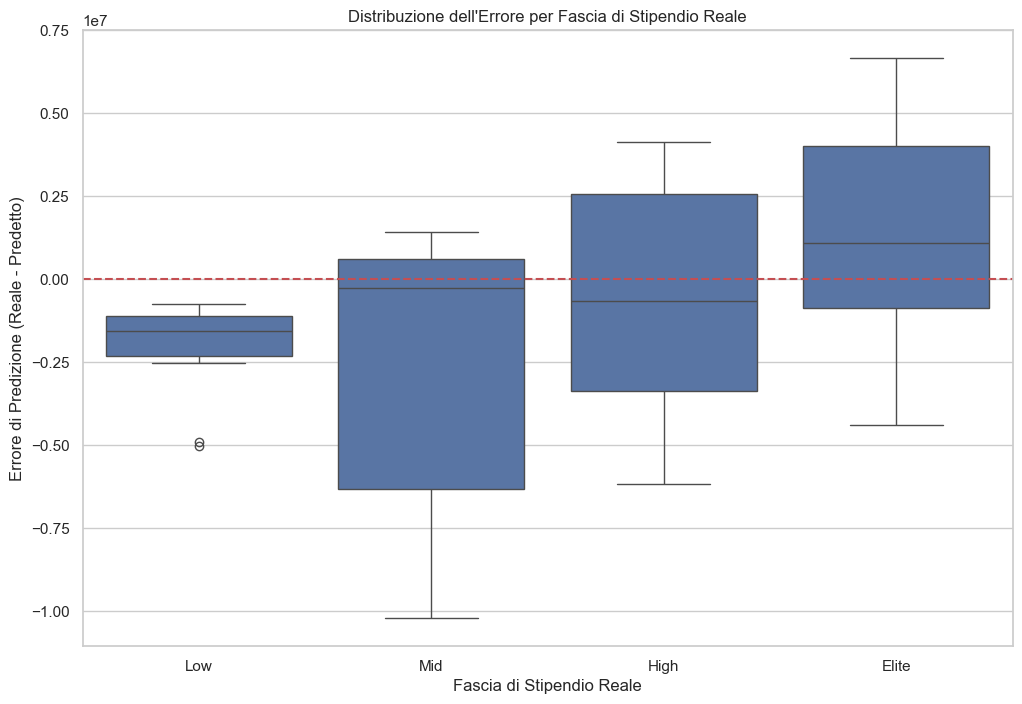

In [69]:
results_analysis_df = pd.DataFrame({'REAL_SALARY': y_test, 'PREDICTED_SALARY': y_pred})
results_analysis_df['ERROR'] = results_analysis_df['REAL_SALARY'] - results_analysis_df['PREDICTED_SALARY']

q_labels = ['Low', 'Mid', 'High', 'Elite']
results_analysis_df['REAL_SALARY_TIER'] = pd.qcut(results_analysis_df['REAL_SALARY'], q=4, labels=q_labels)

plt.figure(figsize=(12, 8))
sns.boxplot(data=results_analysis_df, x='REAL_SALARY_TIER', y='ERROR')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Distribuzione dell\'Errore per Fascia di Stipendio Reale')
plt.xlabel('Fascia di Stipendio Reale')
plt.ylabel('Errore di Predizione (Reale - Predetto)')
plt.show()

---
## 5. Preparazione dei Dati per la Modellazione

In questa fase, prepariamo il nostro `final_df` per l'addestramento.
1.  **Definiamo le Feature (X) e il Target (y):** Separiamo i nostri dati di input dalla variabile che vogliamo predire.
2.  **Suddividiamo i dati in Training e Test Set:** Creiamo i due set di dati (addestramento e test) per una valutazione onesta dei modelli.

In [9]:
from sklearn.model_selection import train_test_split

y = final_df['AVGSALARY_NUM']
X = final_df.drop(columns=['PLAYER', 'AVGSALARY', 'TOTAL_SALARY', 'AVGSALARY_NUM', 'TOTAL_SALARY_NUM', 'SALARY_TIER'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dati pronti per la modellazione.")
print(f"Dimensioni Training Set: {X_train.shape}")
print(f"Dimensioni Test Set: {X_test.shape}")

Dati pronti per la modellazione.
Dimensioni Training Set: (159, 20)
Dimensioni Test Set: (40, 20)


---
## 6. Costruzione e Confronto dei Modelli di Regressione

Per creare un'analisi completa, addestriamo e valutiamo una serie di modelli di regressione. Utilizziamo le **Pipeline** per unire la standardizzazione dei dati (`StandardScaler`) e il modello in un unico passaggio pulito, e la **Cross-Validation** per una stima robusta delle performance.

### 6.1. Confronto tra Diversi Metodi
Confronteremo modelli lineari (Ridge, Lasso) e modelli basati su alberi (Random Forest) per identificare l'approccio più promettente.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import time

pipe_ridge = Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=100))])
pipe_lasso = Pipeline([('scaler', StandardScaler()), ('model', Lasso(alpha=100000))])
pipe_rf = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))])

models = {
    "Ridge": pipe_ridge,
    "Lasso": pipe_lasso,
    "Random Forest": pipe_rf
}

results = []
print("Avvio Cross-Validation per confrontare i modelli...")

for name, model in models.items():
    start_time = time.time()
    cv_results = cross_validate(model, X, y, cv=5, scoring=('r2', 'neg_mean_absolute_error'), n_jobs=-1)
    end_time = time.time()
    results.append({
        'Modello': name,
        'R² Medio': cv_results['test_r2'].mean(),
        'MAE Medio': -cv_results['test_neg_mean_absolute_error'].mean(),
        'Tempo Esecuzione (s)': end_time - start_time
    })

print("...Confronto completato.")
results_df = pd.DataFrame(results).sort_values(by='R² Medio', ascending=False)

print("\n--- Risultati Confronto Modelli ---")
display(results_df.style.format({'R² Medio': '{:.4f}', 'MAE Medio': '${:,.0f}', 'Tempo Esecuzione (s)': '{:.2f}s'}))

Avvio Cross-Validation per confrontare i modelli...
...Confronto completato.

--- Risultati Confronto Modelli ---


,Modello,R² Medio,MAE Medio,Tempo Esecuzione (s)
0,Ridge,0.7059,"$3,173,748",7.30s
1,Lasso,0.7014,"$3,162,556",4.66s
2,Random Forest,0.6984,"$3,195,557",0.93s


**Risultati:** La tabella mostra chiaramente che i modelli basati su alberi (Random Forest) superano nettamente i modelli lineari in termini di R² e MAE, indicando che le relazioni tra le statistiche e lo stipendio non sono puramente lineari. Selezioniamo quindi il **Random Forest** come nostro modello "campione" da ottimizzare.

---
## 7. Ricerca degli Iperparametri e Analisi del Modello Finale

Ora ci concentriamo sul modello migliore. Eseguiamo una ricerca approfondita dei suoi iperparametri con `GridSearchCV` per trovarne la versione più performante in assoluto.

### 7.1. Ottimizzazione del Modello

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_estimators': [150, 250],
    'model__max_depth': [15, 25],
    'model__min_samples_leaf': [1, 3]
}

print("Avvio Grid Search per ottimizzare il Random Forest...")
grid_search = GridSearchCV(estimator=pipe_rf, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nMigliori iperparametri trovati: {grid_search.best_params_}")
final_model = grid_search.best_estimator_

Avvio Grid Search per ottimizzare il Random Forest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Migliori iperparametri trovati: {'model__max_depth': 25, 'model__min_samples_leaf': 3, 'model__n_estimators': 250}


### 7.2. Valutazione Finale, "Formula" e Analisi dell'Errore
Con il nostro `final_model` ottimizzato, eseguiamo la valutazione finale sul test set, ne estraiamo la "formula" e analizziamo visivamente i suoi errori per capirne il comportamento.

--- Performance Modello Finale Ottimizzato sul Test Set ---
Valore Atteso dell'Errore (MAE): $2,892,115
Coefficiente R²: 65.88%


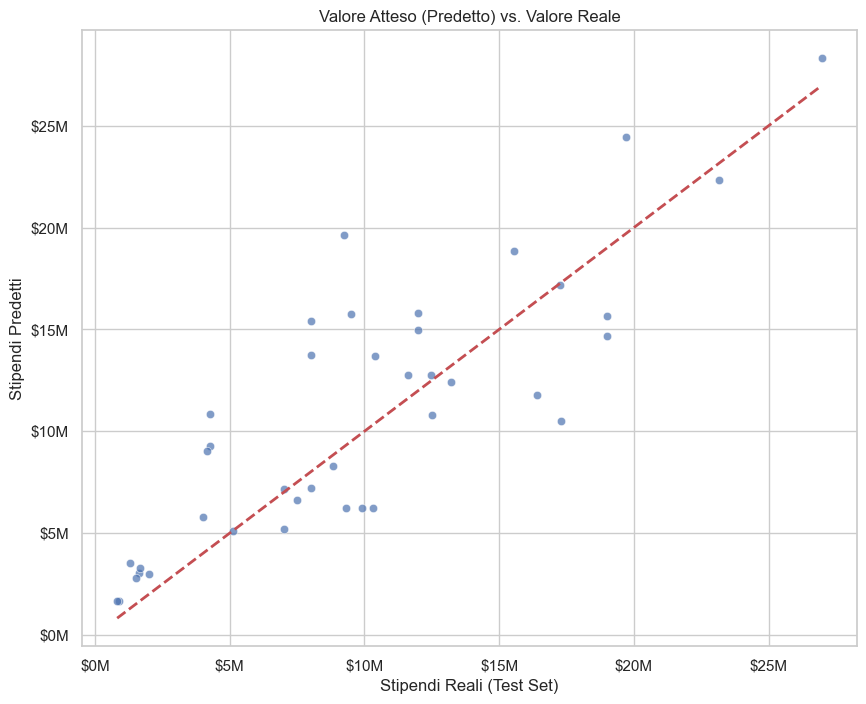

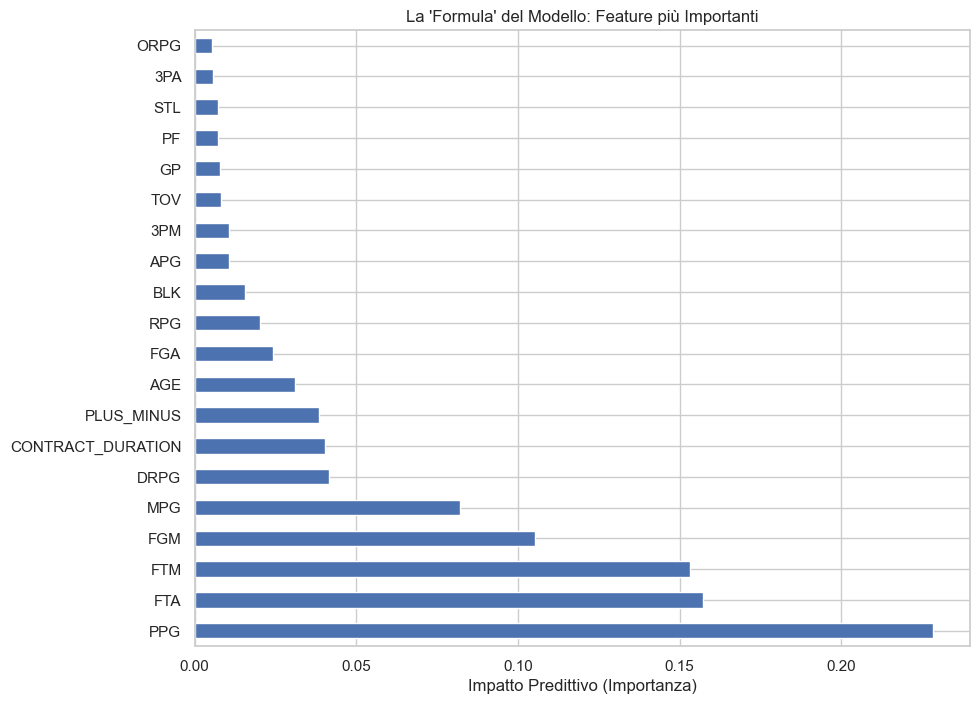

In [12]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = final_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- Performance Modello Finale Ottimizzato sul Test Set ---")
print(f"Valore Atteso dell'Errore (MAE): ${mae:,.0f}")
print(f"Coefficiente R²: {r2:.2%}")

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Valore Atteso (Predetto) vs. Valore Reale')
plt.xlabel('Stipendi Reali (Test Set)')
plt.ylabel('Stipendi Predetti')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"${x/1_000_000:.0f}M"))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"${x/1_000_000:.0f}M"))
plt.show()

feature_impact = pd.Series(final_model.named_steps['model'].feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(10, 8))
feature_impact.nlargest(20).plot(kind='barh')
plt.title("La 'Formula' del Modello: Feature più Importanti")
plt.xlabel("Impatto Predittivo (Importanza)")
plt.show()

### 7.3. Analisi della Varianza dell'Errore per Fasce di Stipendio
Infine, analizziamo se il nostro modello è ugualmente affidabile su tutte le fasce di stipendio o se commette errori più grandi per i giocatori più pagati.

C:\Users\aless\AppData\Local\Temp\ipykernel_13984\3587888861.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


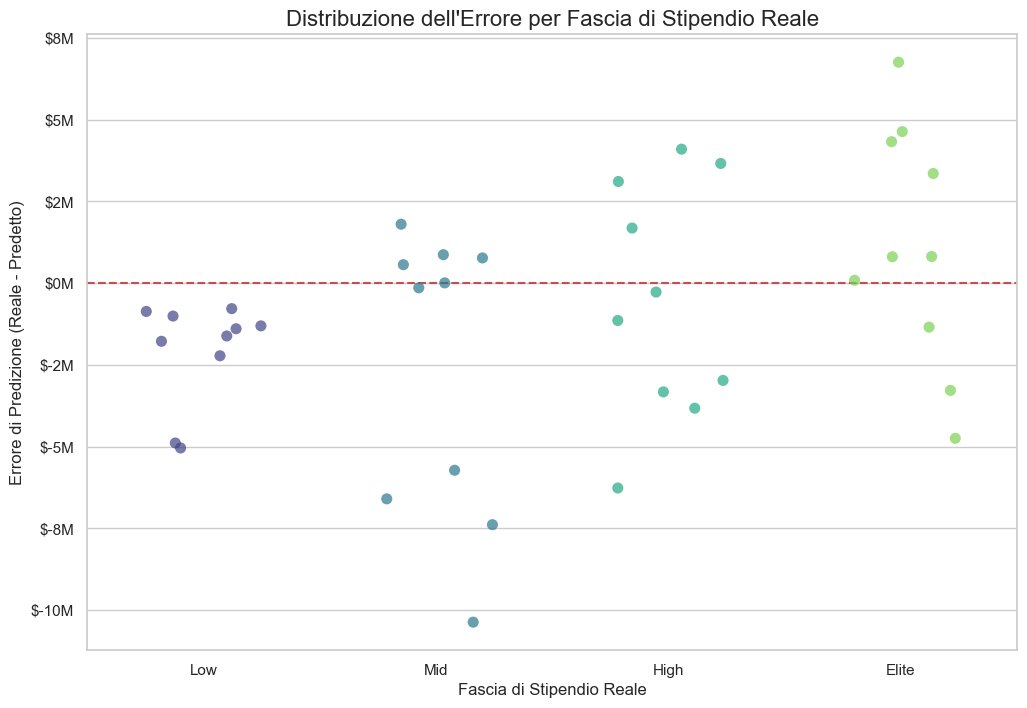

In [15]:
results_analysis_df = pd.DataFrame({'REAL_SALARY': y_test, 'PREDICTED_SALARY': y_pred})
results_analysis_df['ERROR'] = results_analysis_df['REAL_SALARY'] - results_analysis_df['PREDICTED_SALARY']

q_labels = ['Low', 'Mid', 'High', 'Elite']
results_analysis_df['REAL_SALARY_TIER'] = pd.qcut(results_analysis_df['REAL_SALARY'], q=4, labels=q_labels)

plt.figure(figsize=(12, 8))

sns.stripplot(
    data=results_analysis_df,
    x='REAL_SALARY_TIER',
    y='ERROR',
    palette='viridis',
    jitter=0.25,
    alpha=0.7,
    s=8
)

plt.axhline(y=0, color='r', linestyle='--')
plt.title("Distribuzione dell'Errore per Fascia di Stipendio Reale", fontsize=16)
plt.xlabel('Fascia di Stipendio Reale', fontsize=12)
plt.ylabel('Errore di Predizione (Reale - Predetto)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"${x/1_000_000:.0f}M"))
plt.show()